# Отток клиентов

## Подготовка данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from warnings import simplefilter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import warnings

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
data['Surname'].nunique()

2932

In [5]:
#проверяю количество NAN значений
data['Tenure'].isna().sum()

909

***У нас есть 2 столбца значения в которых нужно заменить числовыми это Geography,Gender.В столбце Surname 2932 уникальных значения,я не думаю что для обучения модели нам понадобится этот столбец,поэтому считаю нужным удалить его.А так же в столбце Tenure есть значения NAN,я предлагаю заменить их нолями.Так же предлагаю убрать столбцы RowNumber и CustomerId,считаю что для построения моделей они нам не пригодятся.Я полагаю что возможной причиной появления пропусков в столбце Tenure является то что клиент новый***

In [6]:
data['Tenure'] = data['Tenure'].fillna(0.0)
data['Tenure'].isna().sum()

0

In [7]:
data_ohe = data.drop(['Surname','CustomerId','RowNumber'],axis=1) #удаляю лишние столбцы
data_ohe = pd.get_dummies(data_ohe,drop_first=True)
data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


***Собираюсь проверить оставшиеся данные на мультиколлинеарность факторов***

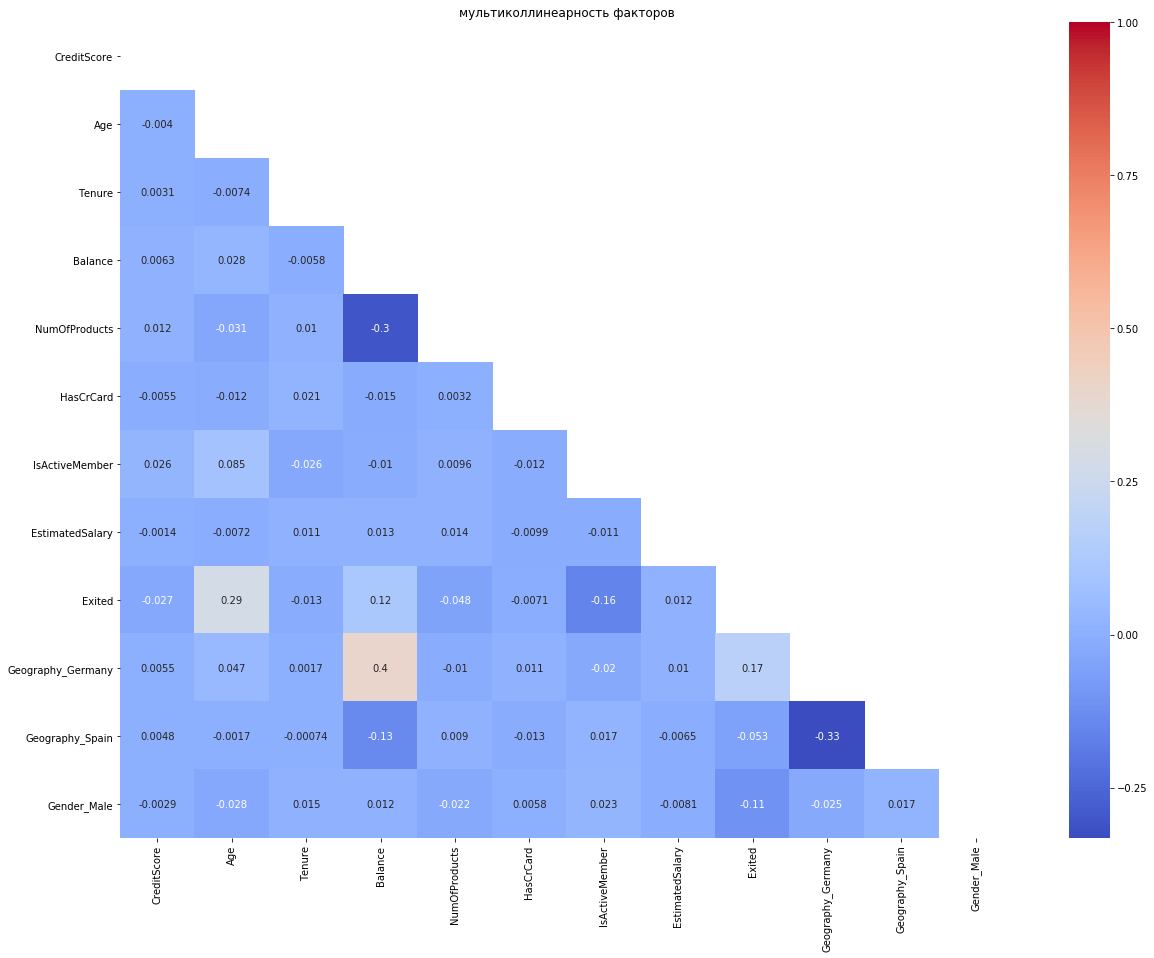

In [8]:
matrix = np.triu(data_ohe.corr())
plt.figure(figsize=(20,15))
hm = sns.heatmap(data_ohe.corr(),cbar=True,annot=True,cmap= 'coolwarm',mask=matrix)
hm.set_title('мультиколлинеарность факторов');

In [9]:
#нармализация признаков
#scaler = preprocessing.MinMaxScaler()
#names = data_ohe.columns
#d = scaler.fit_transform(data_ohe)

#scaled_df = pd.DataFrame(d, columns=names)
#scaled_df.head()

***На данном этапе четкая корреляция не прослеживается,можно отметить только корреляцию баланса и Германии.Видимо это связано с тем что в этой стране балансы на счетах самые большие***

In [10]:
#разобью данные на выборки
# создам переменные для признаков и целевого признака
target = data_ohe['Exited']
features = data_ohe.drop(['Exited'] , axis=1)
features_train, features_valid,target_train, target_valid = train_test_split(
    features, target, test_size=0.5, random_state=12345,stratify=target)
features_valid,features_test,target_valid,target_test = train_test_split(
    features_valid,target_valid,test_size=0.5,random_state=12345,stratify=target_valid)
    
#Исследую размеры выборок
print('Размер обучающей выборки:',features_train.shape)
print('Размер валидационной выборки:',features_valid.shape)
print('Размер тестовой выборки:',features_test.shape)

Размер обучающей выборки: (5000, 11)
Размер валидационной выборки: (2500, 11)
Размер тестовой выборки: (2500, 11)


In [19]:
numeric = ['CreditScore','Age','Tenure','Balance','EstimatedSalary']
scaler = preprocessing.MinMaxScaler()
scaler.fit(features_train)
features_train_scaled = scaler.transform(features_train)
features_valid_scaled = scaler.transform(features_valid)
features_test_scaled = scaler.transform(features_test)
features_train_scaled = pd.DataFrame(features_train_scaled)
features_valid_scaled = pd.DataFrame(features_valid_scaled)
features_test_scaled = pd.DataFrame(features_test_scaled)

***Я загрузил и исследовал данные,удалил столбцы Surname,CustomerId,RowNumber.Данные разбил на выборки и проверил на мультиколлинеарность***

## Исследование задачи

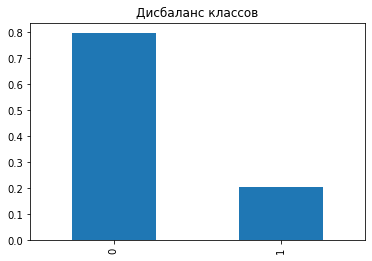

In [20]:
#Собираюсь обучить модели 
#Модель Решающее дерево
model_Tree = DecisionTreeClassifier(random_state=12345)
model_Tree.fit(features_train_scaled,target_train)
#Модель Случайного леса
model_Forest = RandomForestClassifier(random_state=12345)
model_Forest.fit(features_train_scaled,target_train)
#Модель Линейной ригрессии
model_Regression = LogisticRegression(random_state=12345, solver='liblinear',class_weight='balanced')
model_Regression.fit(features_train_scaled,target_train)

#посмотрю дисбаланс классов
test = data_ohe['Exited'].value_counts(normalize=True).plot(kind='bar')
test.set_title("Дисбаланс классов");

In [21]:
test_train = target_train.value_counts(normalize=True)
test_valid = target_valid.value_counts(normalize=True)
test_test = target_test.value_counts(normalize=True)
print('Обучающая выборка')
print(test_train)
print('Валидационная выборка')
print(test_valid)
print('Тестовая выборка')
print(test_test)

Обучающая выборка
0    0.7962
1    0.2038
Name: Exited, dtype: float64
Валидационная выборка
0    0.7964
1    0.2036
Name: Exited, dtype: float64
Тестовая выборка
0    0.7964
1    0.2036
Name: Exited, dtype: float64


In [22]:
train = 2038 / 7962
valid = 2036 / 7964
test = valid
mean = (train+valid+test)/3
print('Диссбаланс данных в обучающей выборке:{:.2%}'.format(train))
print('Диссбаланс данных в валидационной выборке:{:.2%}'.format(valid))
print('Диссбаланс данных в тестовой выборке:{:.2%}'.format(test))
print('среднее значение диссбаланса:{:.2%}'.format(mean))

Диссбаланс данных в обучающей выборке:25.60%
Диссбаланс данных в валидационной выборке:25.57%
Диссбаланс данных в тестовой выборке:25.57%
среднее значение диссбаланса:25.58%


***На графике выше и чуть ниже него я наглядно представил дисбаланс классов во всех выборках.В среднем значения 0 встречаются на 25% чаще***

## Борьба с дисбалансом

Подберу лучшие параметры для модели Решающее дерево

In [23]:
#решающее дерево
for depth in range(1,20):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train_scaled,target_train)
    predictions_valid = model.predict(features_valid_scaled)
    
    print("max_depth =", depth, ": ", end='')
    print(f1_score(target_valid, predictions_valid))

max_depth = 1 : 0.0
max_depth = 2 : 0.4920440636474908
max_depth = 3 : 0.35239567233384855
max_depth = 4 : 0.49408672798948755
max_depth = 5 : 0.4884667571234736
max_depth = 6 : 0.540272614622057
max_depth = 7 : 0.5683709869203329
max_depth = 8 : 0.5572254335260116
max_depth = 9 : 0.5507246376811593
max_depth = 10 : 0.5389610389610389
max_depth = 11 : 0.5199568500539374
max_depth = 12 : 0.5341745531019979
max_depth = 13 : 0.5344295991778005
max_depth = 14 : 0.5212121212121213
max_depth = 15 : 0.5113524185587364
max_depth = 16 : 0.5137254901960785
max_depth = 17 : 0.5014691478942213
max_depth = 18 : 0.5116279069767442
max_depth = 19 : 0.5125725338491295


***Я ищу лучшие показатели глубины в промежутке от 1 до 20 чтобы не переобучить модель,лучшие показатели у модели с глубиной 7***

In [24]:
model_Tree = DecisionTreeClassifier(random_state=12345,max_depth=7,class_weight='balanced')
model_Tree.fit(features_train_scaled,target_train)
predict_model_Tree_valid = model_Tree.predict(features_valid_scaled)
predict_model_Tree_train = model_Tree.predict(features_train_scaled)
print("F1 на валидационной выборке:", f1_score(target_valid,predict_model_Tree_valid))
print("F1 на тренировочной выборке: ",f1_score(target_train,predict_model_Tree_train))
print("Recall на валидационной выборке:",recall_score(target_valid,predict_model_Tree_valid))
print("Precision на валидационной выборке:",precision_score(target_valid,predict_model_Tree_valid))
print("Accuracy на валидационной выборке:",accuracy_score(target_valid,predict_model_Tree_valid))

F1 на валидационной выборке: 0.5534407027818449
F1 на тренировочной выборке:  0.6356472795497186
Recall на валидационной выборке: 0.7426326129666012
Precision на валидационной выборке: 0.441073512252042
Accuracy на валидационной выборке: 0.756


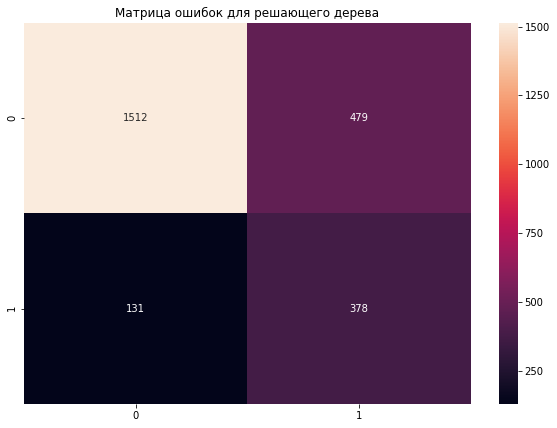

In [25]:
confusion_matrix_tree = confusion_matrix(target_valid,predict_model_Tree_valid)
plt.figure(figsize = (10,7))
sns.heatmap(confusion_matrix_tree, annot=True,fmt="d");
plt.title('Матрица ошибок для решающего дерева');

***На данном этапе модель решающего леса показывает значение F1 равное 0,55.Так же для наглядности я вывел матрицу ошибок,глядя на нее я могу судить что верно положительных ответов почти в 3 раза больше чем ложноположительных.Верноотрицательных ответов больше в 4 раза чем ложноотрицательных***

Собираюсь подобрать лучшие параметры для модели случайного леса

In [26]:
#model_Forest = RandomForestClassifier()
#parametrs = { 'n_estimators': range (10, 51, 10),
              #'max_depth': range (1,13, 2),
              #'min_samples_leaf': range (1,8),
              #'min_samples_split': range (2,10,2) }
#grid = GridSearchCV(model_Forest, parametrs, cv=5)
#grid.fit(features_train, target_train)
#grid.best_params_

#В этом блоке я пытался произвести подбор параметров и перепробовал кучу приемов,но у меня не получилось,если вы подскажете код
#то я буду очень вам благодарен

In [27]:
for depth in range(1,20):
    model = RandomForestClassifier(random_state=12345, max_depth=depth,class_weight='balanced')
    model.fit(features_train_scaled,target_train)
    predictions_valid = model.predict(features_valid_scaled)
    
    print("max_depth =", depth, ": ", end='')
    print(f1_score(target_valid, predictions_valid))

max_depth = 1 : 0.5014005602240896
max_depth = 2 : 0.5525291828793774
max_depth = 3 : 0.5552147239263803
max_depth = 4 : 0.5862068965517241
max_depth = 5 : 0.582053354890865
max_depth = 6 : 0.578391551584078
max_depth = 7 : 0.5784716516023007
max_depth = 8 : 0.5860306643952301
max_depth = 9 : 0.5874769797421732
max_depth = 10 : 0.5841392649903288
max_depth = 11 : 0.580104712041885
max_depth = 12 : 0.581270182992465
max_depth = 13 : 0.5627802690582959
max_depth = 14 : 0.5524475524475524
max_depth = 15 : 0.5497630331753555
max_depth = 16 : 0.519159456118665
max_depth = 17 : 0.5206812652068126
max_depth = 18 : 0.5232704402515723
max_depth = 19 : 0.5152284263959391


***Лучшим вариантом глубины обучения является 9***

In [28]:
%%time
for estimators in range(1, 101, 1):
    model = RandomForestClassifier(random_state=12345,max_depth=9,class_weight='balanced',n_estimators=estimators)
    model.fit(features_train_scaled,target_train)
    predictions_valid = model.predict(features_valid_scaled)
    
    print("n_estimators = ", estimators, ": ", end='')
    print(f1_score(target_valid, predictions_valid))

n_estimators =  1 : 0.5142428785607197
n_estimators =  2 : 0.512589928057554
n_estimators =  3 : 0.56195462478185
n_estimators =  4 : 0.5503231763619575
n_estimators =  5 : 0.5772811918063314
n_estimators =  6 : 0.5872420262664165
n_estimators =  7 : 0.588126159554731
n_estimators =  8 : 0.5817843866171004
n_estimators =  9 : 0.5903165735567971
n_estimators =  10 : 0.5874769797421732
n_estimators =  11 : 0.6007393715341959
n_estimators =  12 : 0.5974264705882352
n_estimators =  13 : 0.5886722376973075
n_estimators =  14 : 0.584022038567493
n_estimators =  15 : 0.5872576177285318
n_estimators =  16 : 0.5943482224247949
n_estimators =  17 : 0.5944444444444443
n_estimators =  18 : 0.5936920222634509
n_estimators =  19 : 0.587906976744186
n_estimators =  20 : 0.5892193308550187
n_estimators =  21 : 0.5824884792626728
n_estimators =  22 : 0.5981481481481482
n_estimators =  23 : 0.5884543761638733
n_estimators =  24 : 0.5918367346938775
n_estimators =  25 : 0.5938945420906567
n_estimators = 

***Лучшим показателем n_estimators является 66.Поиск этого параметра занял 34 секунды,интерсно сколько времени понадобится обученной модели для тестовой выборки,проверю это в конце когда буду тестировать лучшую модель.В модели решающего дерева и случайного леса я также добавил параметры random_state=12345 и class_weight='balanced'.Параметр class_weight я добавил чтобы сбалансировать массу классов.***

In [29]:
model_Forest = RandomForestClassifier(random_state=12345,max_depth=9,class_weight='balanced',n_estimators=66)
model_Forest.fit(features_train_scaled,target_train)
predict_model_Forest_valid = model_Forest.predict(features_valid_scaled)
predict_model_Forest_train = model_Forest.predict(features_train_scaled)
print("F1 на валидационной выборке:", f1_score(target_valid,predict_model_Forest_valid))
print("F1 на тренировочной выборке: ",f1_score(target_train,predict_model_Forest_train))
print("Recall на валидационной выборке:",recall_score(target_valid,predict_model_Forest_valid))
print("Precision на валидационной выборке:",precision_score(target_valid,predict_model_Forest_valid))
print("Accuracy на валидационной выборке:",accuracy_score(target_valid,predict_model_Forest_valid))

F1 на валидационной выборке: 0.6073102155576382
F1 на тренировочной выборке:  0.7639015496809481
Recall на валидационной выборке: 0.6365422396856582
Precision на валидационной выборке: 0.5806451612903226
Accuracy на валидационной выборке: 0.8324


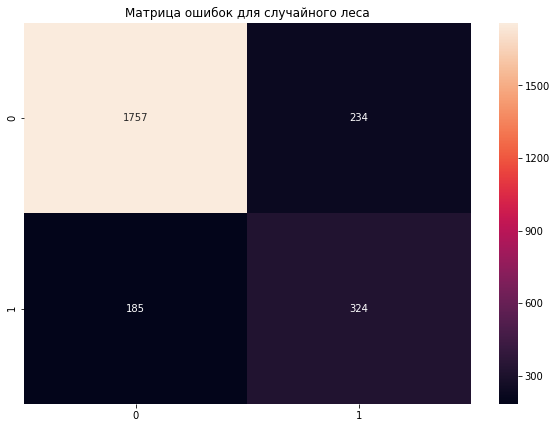

In [30]:
confusion_matrix_forest = confusion_matrix(target_valid,predict_model_Forest_valid)
plt.figure(figsize = (10,7))
sns.heatmap(confusion_matrix_forest, annot=True,fmt="d");
plt.title('Матрица ошибок для случайного леса');

***В модели случайный лес показатели F1 равны 0,60 на валидационной выборке.В матрице ошибок наглядно видно что данная модель предсказывает немного лучше чем модель решающего дерева***

Собираюсь исследовать модель Регрессии

In [31]:
model_Regression = LogisticRegression(random_state=12345, solver='liblinear',class_weight='balanced')
model_Regression.fit(features_train_scaled,target_train)
predict_model_Regression_valid = model_Regression.predict(features_valid_scaled)
predict_model_Regression_train = model_Regression.predict(features_train_scaled)
print("F1 на валидационной выборке:", f1_score(target_valid,predict_model_Regression_valid))
print("F1 на тренировочной выборке: ",f1_score(target_train,predict_model_Regression_train))
print("Recall на валидационной выборке:",recall_score(target_valid,predict_model_Regression_valid))
print("Precision на валидационной выборке:",precision_score(target_valid,predict_model_Regression_valid))
print("Accuracy на валидационной выборке:",accuracy_score(target_valid,predict_model_Regression_valid))

F1 на валидационной выборке: 0.49127704117236565
F1 на тренировочной выборке:  0.49401829697396205
Recall на валидационной выборке: 0.6915520628683693
Precision на валидационной выборке: 0.38095238095238093
Accuracy на валидационной выборке: 0.7084


***На данном этапе модель регрессии имеет показатель F1 на уровне 0,49.Пока что это худший показаетль среди всех моделей***

In [32]:
#хочу сделать масштабирование признаков для модели регресии
pd.options.mode.chained_assignment = None
scaler = StandardScaler().fit(features_train_scaled)
train_scaler = scaler.transform(features_train_scaled)
valid_scaler = scaler.transform(features_valid_scaled)


model_Regression = LogisticRegression(random_state=12345, solver='liblinear',class_weight='balanced')
model_Regression.fit(train_scaler,target_train)
predict_model_Regression = model_Regression.predict(valid_scaler)
print("F1 на валидационной выборке: ", f1_score(target_valid,predict_model_Regression))
print("Recall на валидационной выборке:",recall_score(target_valid,predict_model_Regression))
print("Precision на валидационной выборке:",precision_score(target_valid,predict_model_Regression))

F1 на валидационной выборке:  0.49334267694463907
Recall на валидационной выборке: 0.6915520628683693
Precision на валидационной выборке: 0.38344226579520696


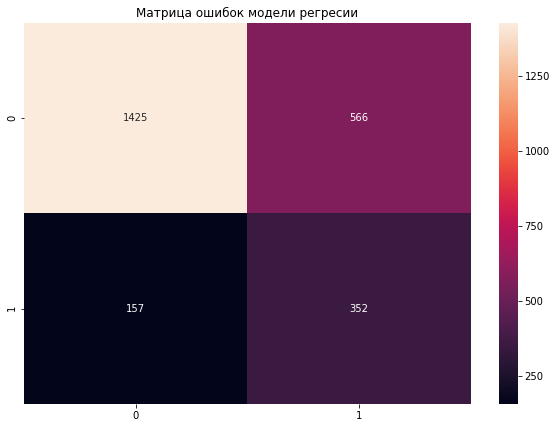

In [33]:
confusion_matrix_Regression = confusion_matrix(target_valid,predict_model_Regression)
plt.figure(figsize = (10,7))
sns.heatmap(confusion_matrix_Regression, annot=True,fmt="d");
plt.title('Матрица ошибок модели регресии');

***Мне не удалось улучшить модель применив масштабирование признаков***

Попробую улучшить показатали моделей увеличив выборки

In [35]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train,4)


model_Tree = DecisionTreeClassifier(random_state=12345,max_depth=7,class_weight='balanced')
model_Tree.fit(features_upsampled,target_upsampled)

model_Forest = RandomForestClassifier(n_estimators=66, max_depth=9, random_state=12345,class_weight='balanced')
model_Forest.fit(features_upsampled,target_upsampled)

model_Regression = LogisticRegression(random_state=12345, solver='liblinear',class_weight='balanced')
model_Regression.fit(features_upsampled,target_upsampled)

predict_model_Tree = model_Tree.predict(features_valid)
predict_model_Forest = model_Forest.predict(features_valid)
predict_model_Regression = model_Regression.predict(features_valid)

print("F1 на валидационной выборке модель решающее дерево: ", f1_score(target_valid,predict_model_Tree))
print("F1 на валидационной выборке модель случайный лес: ", f1_score(target_valid,predict_model_Forest))
print("F1 на валидационной выборке модель регрессии: ", f1_score(target_valid,predict_model_Regression))

F1 на валидационной выборке модель решающее дерево:  0.5534407027818449
F1 на валидационной выборке модель случайный лес:  0.5991416309012875
F1 на валидационной выборке модель регрессии:  0.49127704117236565


Попробую улучшить показатели моделей уменьшив выборки

In [36]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

model_Tree = DecisionTreeClassifier(random_state=12345,max_depth=7,class_weight='balanced')
model_Tree.fit(features_downsampled,target_downsampled)

model_Forest = RandomForestClassifier(n_estimators=66, max_depth=9, random_state=12345,class_weight='balanced')
model_Forest.fit(features_downsampled,target_downsampled)

model_Regression = LogisticRegression(random_state=12345, solver='liblinear',class_weight='balanced')
model_Regression.fit(features_downsampled,target_downsampled)

predict_model_Tree = model_Tree.predict(features_valid)
predict_model_Forest = model_Forest.predict(features_valid)
predict_model_Regression = model_Regression.predict(features_valid)

print("F1 на валидационной выборке модель решающее дерево: ", f1_score(target_valid,predict_model_Tree))
print("F1 на валидационной выборке модель случайный лес: ", f1_score(target_valid,predict_model_Forest))
print("F1 на валидационной выборке модель регрессии: ", f1_score(target_valid,predict_model_Regression))

F1 на валидационной выборке модель решающее дерево:  0.5484598046581517
F1 на валидационной выборке модель случайный лес:  0.5899843505477308
F1 на валидационной выборке модель регрессии:  0.4933051444679353


***Увеличение выборок не привело к улучшению моделей,мне не удалось улучшить модели решающего дерева и регрессии после уменьшения выборок.Модель случайного леса при этих тестах только ухудшилась.*** 

Создам таблицу в которой укажу лучшие параметры по всем моделям

In [37]:
final_df = pd.DataFrame({'test':['F1','Recall','Precision','Accuracy'],
                         'model_Tree':['0.5534','0.7426','0.4410','0.756'],
                         'model_Forest':['0.6073','0.6365','0.5806','0.8324'],
                         'model_Regression':['0.4912','0.6915','0.3809','0.7084']
                        })
final_df

,test,model_Tree,model_Forest,model_Regression
0,F1,0.5534,0.6073,0.4912
1,Recall,0.7426,0.6365,0.6915
2,Precision,0.4410,0.5806,0.3809
3,Accuracy,0.756,0.8324,0.7084


***Исходя из данной таблицы мы можем наблюдать как модель случайного леса превосходит остальные.Именно эту модель я возьму для финального тестирования***

## Тестирование модели

***Для финального тестирования я выбрал модель случайного леса***

In [38]:
#обьединяю выборки
train_valid_features = pd.concat([features_train_scaled,features_valid_scaled],sort=False,axis=0)
train_valid_target = pd.concat([target_train,target_valid],sort=False,axis=0)


In [41]:

%%time
model_Forest = RandomForestClassifier(n_estimators=66, max_depth=9, random_state=12345,class_weight='balanced')
model_Forest.fit(train_valid_features,train_valid_target)
predict_model_Forest = model_Forest.predict(features_test_scaled)
print("F1 на тестовой выборке:", f1_score(target_test,predict_model_Forest))
print("Recall на тестовой выборке:",recall_score(target_test,predict_model_Forest))
print("Precision на тестовой выборке:",precision_score(target_test,predict_model_Forest))

F1 на тестовой выборке: 0.6282722513089006
Recall на тестовой выборке: 0.7072691552062869
Precision на тестовой выборке: 0.565149136577708
CPU times: user 619 ms, sys: 0 ns, total: 619 ms
Wall time: 617 ms


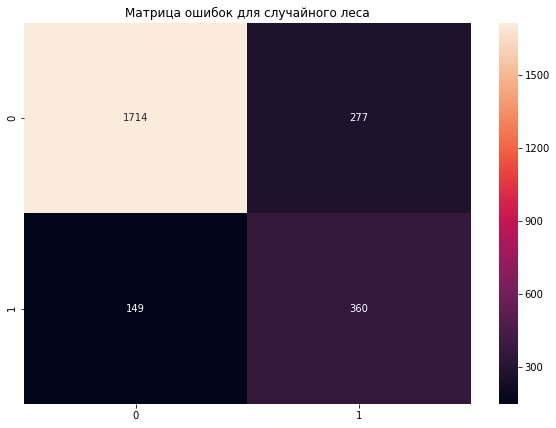

In [42]:
confusion_matrix_forest = confusion_matrix(target_test,predict_model_Forest)
plt.figure(figsize = (10,7))
sns.heatmap(confusion_matrix_forest, annot=True,fmt="d");
plt.title('Матрица ошибок для случайного леса');

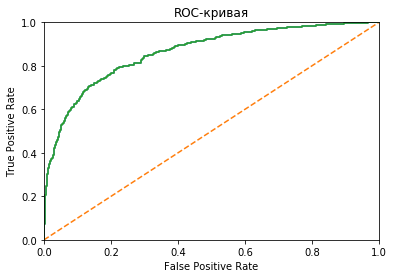

In [43]:
probabilities_valid = model_Forest.predict_proba(features_test_scaled)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_test,probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [44]:
auc_roc = roc_auc_score(target_test,probabilities_valid[:, 1])

print(auc_roc)

0.8636783008804848


### Общий вывод

***Я построил 3 модели:***

- Решающее дерево
- Случайный лес
- Модель Регрессии

***Результата значения F1 равного 0,62 мне удалось достичь с моделью случайного леса.Так же я построил график AUC ROC для модели 'чемпиона',судя по графику нашу модель можно считать адекватной.В тренажере нас учили что модели случайного леса самые медленные,в финальном тестировании модель обучалась и тестировалась метриками,на все это у нее ушло 0,89 секунды.Много это или мало я пока не знаю)***

От меня лично,все красные замечания поправил и постарался исправить практически все желтые

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: задача исследована
    - [ ]  Исследован баланс классов
    - [ ]  Изучены модели без учёта дисбаланса
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 3: учтён дисбаланс
    - [ ]  Применено несколько способов борьбы с дисбалансом
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 4: проведено тестирование
- [ ]  Удалось достичь *F1*-меры не менее 0.59
- [ ]  Исследована метрика *AUC-ROC*